# TITLE

## Final Project Submission

Please fill out:
* __Student name:__ Cassarra Groesbeck
* __Student pace:__ Part Time/ Flex
* __Scheduled project review date/time:__ 
* __Instructor name:__ 
* __Blog post URL:__



# 1. Introduction 

## 1a. Objectives

## 1b. Business Understanding

# 2. Data Understanding
This dataset contains 5110 observations with 12 attributes (11 clinical features) for predicting stroke events. 


### 2a. Attribute Information
| Column     | Description   |
|------------|:--------------|
| `id`               | **unique identifier**  |
| `gender`           | **"Male", "Female" or "Other"**  |
| `age`              | **age of the patient** |
| `hypertension`     | **0 if the patient doesn't have hypertension, 1 if the patient has hypertension**  |
| `heart_disease`    | **0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease**   |
| `ever_married`     | **"No" or "Yes"**  |
| `work_type`        | **"children", "Govt_jov", "Never_worked", "Private" or "Self-employed"**   |
| `Residence_type`   | **"Rural" or "Urban"**  |
| `avg_glucose_level`| **average glucose level in blood**  |
| `bmi`              | **body mass index** |
| `smoking_status`   | **"formerly smoked", "never smoked", "smokes" or "Unknown"***  |
| `stroke`           | **1 if the patient had a stroke or 0 if not**  |
|    **_*Note:_**      | _"Unknown" in_ `smoking_status` _means that the information is unavailable for this patient_ |


### 2b. Acknowledgements
Data comes from the [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) and can be found on [kaggle](https://www.kaggle.com).

# 3. Imports

In [163]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn')
sns.set_style('darkgrid', {'axes.facecolor': '0.9', "grid.color": ".6", "grid.linestyle": ":"})
%matplotlib inline

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

# 4. Exploring the data

### 4a. Load and visually check the data

In [2]:
data = pd.read_csv('Data/healthcare-dataset-stroke-data.csv')

In [3]:
# Visual check of raw df
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 4b. Drop unnecessary column, and identify target feature

In [4]:
# Drop 'id' column
data = data.drop('id', axis=1)

In [5]:
# Identify Target Feature
target = 'stroke'

### 4c. The basics

In [6]:
data.shape

(5110, 11)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [8]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### 4d. Exploring nulls

In [9]:
# percent of missing data
f'{(201/5110)*100:.3}%'

'3.93%'

In [10]:
# just the nulls
bmi_nulls = data[data['bmi'].isnull()]
# `stroke` patients with missing `bmi` data
bmi_nulls['stroke'].value_counts()

0    161
1     40
Name: stroke, dtype: int64

### 4e. Distribution of values

In [11]:
print('-'*30)
print('Distribution of Target Feature')
print('-'*30)
print('COUNTS:')
print(data[target].value_counts())
print('- '*15)
print('PERCENTAGES:')
for value in [norm_value_count for norm_value_count \
                in enumerate(data[target].value_counts(normalize=True))]:
    print(f'{value[0]}\t{value[1]*100:.4}%')
print(f'Name: {target}, dtype: int64') # just for symmetry
print('-'*30)

------------------------------
Distribution of Target Feature
------------------------------
COUNTS:
0    4861
1     249
Name: stroke, dtype: int64
- - - - - - - - - - - - - - - 
PERCENTAGES:
0	95.13%
1	4.873%
Name: stroke, dtype: int64
------------------------------


In [12]:
show = data.drop(target, axis=1)

print("-"*30)
print(f'Distribution of Other Features')
print("-"*30)
for column in show.columns:
    print("-"*30)
    print(f"UNIQUE VALUES: {len(show[column].unique())}")
    if len(show[column].unique()) <= 5:
        print("- "*15)
        print(show[column].value_counts())
    else:
        print("- "*15)
        print(f'\t\t  MIN: {show[column].min()}')
        print(f'\t\t  MEAN: {round(show[column].mean())}')
        print(f'\t\t  MAX: {show[column].max()}')
        print((f'Name: {column}, dtype: float64')) 
    print("-"*30)

------------------------------
Distribution of Other Features
------------------------------
------------------------------
UNIQUE VALUES: 3
- - - - - - - - - - - - - - - 
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
------------------------------
------------------------------
UNIQUE VALUES: 104
- - - - - - - - - - - - - - - 
		  MIN: 0.08
		  MEAN: 43.0
		  MAX: 82.0
Name: age, dtype: float64
------------------------------
------------------------------
UNIQUE VALUES: 2
- - - - - - - - - - - - - - - 
0    4612
1     498
Name: hypertension, dtype: int64
------------------------------
------------------------------
UNIQUE VALUES: 2
- - - - - - - - - - - - - - - 
0    4834
1     276
Name: heart_disease, dtype: int64
------------------------------
------------------------------
UNIQUE VALUES: 2
- - - - - - - - - - - - - - - 
Yes    3353
No     1757
Name: ever_married, dtype: int64
------------------------------
------------------------------
UNIQUE VALUES: 5
- 

#### Visualization of above distributions 

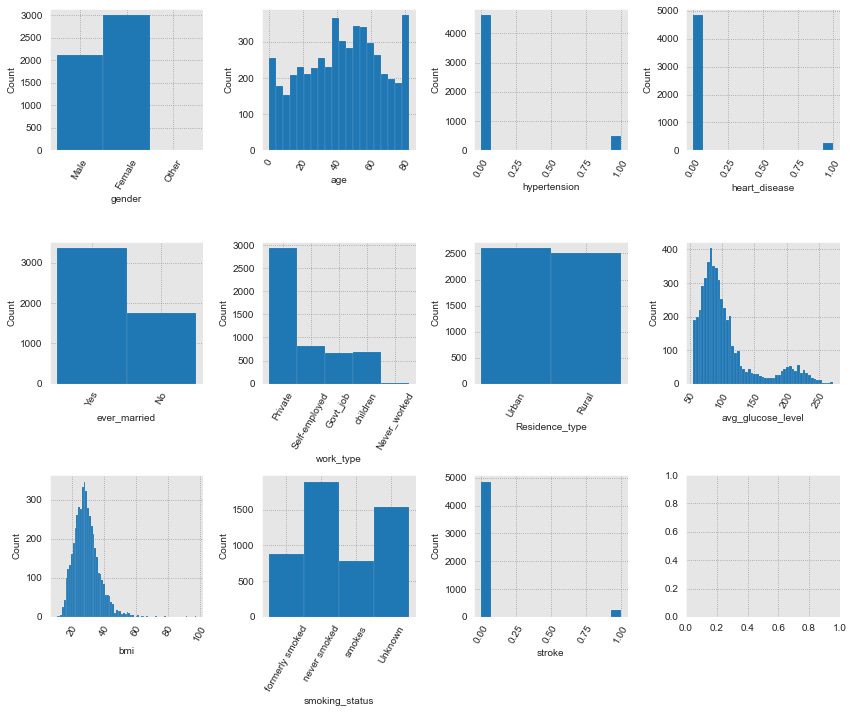

In [39]:
# setup
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(12, 10))
fig.set_tight_layout(True)
# plot
for index, col in enumerate(data.columns):
    ax = axes[index//4][index%4]
    sns.histplot(data=data[col], ax=ax, linewidth=0.1, alpha=1)
    ax.tick_params(axis='x', rotation=60)

### 4f. Findings

- `gender`
 - There is only 1 'other' value, for simplicity I will drop this 1 row.
 - About 1000 more women than men in this dataset.
- `age`
 - The youngest patient is under 1 yo.
 - Oldest patient is 82.
 - Average age of patients in this dataset are 43 years old. 
- `hypertension`
 - Binary, 1 if the patient has hypertension.
 - Very similar distribution as target feature.
- `heart_disease`
 - Binary, 1 if the patient has heart disease.
 - Almost identical distribution as target feature.
 - I am curious how `hypertension` & `heart_disease` will correlate with eachother. 
- `ever_married`
 - About 65/35 split with majority of patients listed as 'Yes.'
- `work_type`
 - Only 5 categories. Not surprisingly, more than half answered 'Private.'
 - Other 4 make up little more than 40%.
 - 'Never_worked' is less than 1%.
- `Residence_type`
 - Almost 50/50 split between 'Urban' and 'Rural.'
- `avg_glucose_level` & `bmi` 
 - continuous features that are both skewed to the right.
 - `bmi` is missing 201 values (3.93%). Of those missing values, 40 are stroke patients.
- `smoking_status`
 - about 30% of patients are listed as 'Unknown.'


# 5. Split the data

### 5a. Separate data into features (X) and target (y)

In [35]:
X = data.drop(target, axis = 1)
y = data[target]

### 5a. Split data into train and test sets

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y, 
                                                    test_size=.2, 
                                                    random_state=42)

# 6. Functions

### 6something. Monster Function

In [276]:
def test_check_model(model,
                     data=data, 
                     target=target, 
                     test_size=.20, 
                     random_state=42, 
                     imputer=None,
                     smote=None,             
                     scaler=None,
                     grid_search=True,
                     param_dict=None,
                     use_test_data=False, 
                     show_thresholds_table=False,  
                     show_plots=False,
                     display_labels=None):
    
    """   
    Uses sklearn.model_selection.train_test_split to divide data into train and test sets, 
    sklearn.preprocessing.StandardScaler to scale data,
    sklearn.model_selection.GridSearchCV -or- sklearn.model_selection.RandomizedSearchCV to 
    search best paramaeters for model. 
    Option to specify use of Test data for outputs.
    
    
    Output
    ---------- 
    (optional) Classification Report
    (optional) Thresholds, FPRs, TPRs Stats Table with AUC score
    (optional) Plots Confusion matrix and if available an ROC curve
    
    
    Returns
    ----------
    Accuracy, Precision, and Recall scores
    
    
    Parameters
    ----------
 
    model : supervised learning model to be evaluated. 
    
    pipe_grid_param_dict : dict or list of dictionaries
        sklearn.model_selection.GridSearchCV parameter: 
            Dictionary with parameters names (`str`) as keys and lists of
            parameter settings to try as values, or a list of such
            dictionaries, in which case the grids spanned by each dictionary
            in the list are explored. This enables searching over any sequence
            of parameter settings.
    
    data : pandas data frame, default=data
    
    target : string or variable set to a string, default=target
    
    test_size : float or int, default=.20
        sklearn.model_selection.train_test_split parameter:
            If float, should be between 0.0 and 1.0 and represent the proportion
            of the dataset to include in the test split. If int, represents the
            absolute number of test samples.
    
    random_state : int or RandomState instance, default=42
        Controls the shuffling applied to the data before applying the split.
        Pass an int for reproducible output across multiple function calls.

    use_test_data : boolean True or False, default=False
        determines the data used to asses model performance
    
    show_thresholds_report : boolean True or False, default=False
        Print table with AUC score, Thresholds, FPR's and TPR's
    
    show_plots : boolean True or False, default=False
        If target variable is binary, plots Confusion Matrix and ROC curve.
        Otherwise just Confusion Matrix
    
    display_labels : list or 'None', default=None
        If the target is binary 0,1 the labels can be changed to more descriptive labels. 
        example: ['Healthy', 'HeartDisease']

    """
    
    
    ######################################################################
    # 1. SEPARATE AND SPLIT DATA                                         #
    ######################################################################    
    
    
    # 1. Separate data into features and target 
    X = data.drop(target, axis = 1)
    y = data[target]
    
    
    # 1. Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        stratify=y, 
                                                        test_size=test_size, 
                                                        random_state=random_state)

        
    ######################################################################
    # 2. TRANSFORM DATA PIPELINE                                         #
    ######################################################################   
    
    
    # 2a. Seperate by type of data
    X_train_nums = X_train.select_dtypes('float64')
    X_train_cat = X_train.select_dtypes('object')


    # 2b. Pipeline 1 (numerical data)
    numerical_pipeline = Pipeline(steps=[
        ('ss', scaler)])
    
    
    # 2c. Pipeline 2 (categorical data)  
    categorical_pipeline = Pipeline(steps=[
        ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])


    # 2d. Converge pipelines 1 & 2
    trans = ColumnTransformer(transformers=[
        ('numerical', numerical_pipeline, X_train_nums.columns),
        ('categorical', categorical_pipeline, X_train_cat.columns)])
        
    
    # 2e. Model with converged pipeline
    model_pipe = imbpipeline(steps=[
        ('trans', trans),
        ('imputer', imputer),
        ('smote', smote),
        ('model', model)])

    
    ######################################################################
    # 3. GRID SEARCH PIPELINE                                            #
    ######################################################################   
    

    # 3a. Determine if using gridsearch
    if grid_search:
        best_model = GridSearchCV(estimator=model_pipe, 
                           param_grid=param_dict, 
                           scoring='recall', 
                           cv=3)

    # fit the model to evaluate
        fit_model = best_model.fit(X_train, y_train) 
    
    else: 
        fit_model = model_pipe.fit(X_train, y_train) 
   

    
    ######################################################################
    # 3. PRINT MODEL DETAILS                                             #
    ######################################################################

    # 3a. Determine if using GridSearch
    if grid_search:
        """
        Use .best_params_ dict and reformat to print the same way 
        classifiers/scalers/imputers etc are instantiated.
        
        
        Example: 
        ----------
        
           .best_params_ = {'model__criterion': 'gini', 
                            'model__max_depth': 6, 
                            'scaler__with_mean': True} 

            prints as: 
                DecisionTreeClassifier(criterion='gini', max_depth=6) 
                StandardScaler(with_mean=True)
        """
        
        kind_of_params = {}
        for k,v in fit_model.best_params_.items():
            key = k.split("__")[0]
            if key not in kind_of_params.keys():
                kind_of_params[key] = "" 
            if k.split("__")[1] == 'solver':
                kind_of_params[key] += k.split("__")[1]+"='"+str(v)+"', " # solver has qoutes around it
            elif k.split("__")[1] == 'criterion':
                kind_of_params[key] += k.split("__")[1]+"='"+str(v)+"', " # criterion has qoutes around it
            else: 
                kind_of_params[key] += k.split("__")[1]+"="+str(v)+", " #<-- notice comma


        # Remove extra comma at end of each value, to display as: param1=value, ..., paramN=value
        for k, v in kind_of_params.items():
            kind_of_params[k] = v[:-2]


        # Use new kind_of_params dict to print: ex. DecisionTreeClassifier(criterion='gini')
        if 'model' in  kind_of_params.keys():
            model_text = str(model).split(")")[0]+", "+kind_of_params['model']+")"
            print(model_text) # <-- To display: Model(param1=value, ..., paramN=value)
        else:
            print(model) # otherwise, use what was fed into function

   
        if 'imputer' in kind_of_params.keys():
            imputer_text = str(imputer).split("()")[0]+"("+kind_of_params['imputer']+")"
            print(imputer_text)
        else:
            print(imputer)


        if scaler != None:
            if 'scaler' in kind_of_params.keys():
                scaler_text = str(scaler).split("()")[0]+"("+kind_of_params['scaler']+")"
                print(scaler_text) 
            else:
                print(scaler)  


        if smote != None:
            if 'smote' in kind_of_params.keys():
                smote_text = str(smote).split(")")[0]+", "+kind_of_params['smote']+")"
                print(smote_text)
            else:
                print(smote)

    else: # if bypassing GridSearch 
        
        # model & imputer
        print(model) # <-- use what was fed into function, example: DecisionTreeClassifier()
        print(imputer)

        # Determine if scaler and/or smote used  
        if scaler != None:  
            print(scaler)
        if smote != None:
            print(smote)
            
    # 3b. To display type of data  
    if use_test_data:
        data_used_text = "Test"
    else:
        data_used_text = "Training"
    
    print(f'\nModel evaluated with {data_used_text} data\n')


DecisionTreeClassifier(random_state=42)
SimpleImputer()
SMOTENC(categorical_features=[0, 4, 5, 6, 9], random_state=42)


In [249]:
scaler

StandardScaler()

In [40]:
 
    ######################################################################
    # 4. (Optional) CLASSIFICATION REPORT                                #
    ######################################################################

    
    # 4a. Determine if using test data for model evaluation
    if use_test_data:
        X_true = X_test
        y_true = y_test
    else: 
        X_true = X_train
        y_true = y_train
        
        
    # 4b. Make predictions and print report 
    y_preds = fit_model.predict(X_true)
    cr = classification_report(y_true, y_preds, digits=4)
    
    print('-'*54)
    print('\t\tCLASSIFICATION REPORT')
    print('-'*54)
    print(cr)
    print('-'*54)
        
        
    ######################################################################
    # 5. Optional. THRESHOLDS TABLE                                      #
    ######################################################################   
   
     if show_thresholds_table:
        
        # Calculate the probability scores
        if ('LogisticReg' in str(model)):
            y_score = fit_model.decision_function(X_true) 
            fpr, tpr, thresholds = roc_curve(y_true, y_score)
        else:
            y_score = fit_model.predict_proba(X_true)
            fpr, tpr, thresholds = roc_curve(y_true, y_score[:,1]) # <-- probability of Class 1

        # To display as: THRESHOLD: value | FPR: percent%, TPR:percent%
        thresh_fp_tp = list(zip(thresholds, fpr, tpr))
        these_to_print = [f'THRESHOLD: {e[0]:.2f} | FPR: {e[1]:.2%}, TPR:{e[2]:.2%}' \
                          for e in thresh_fp_tp]        
        auc = auc(fpr, tpr)
        
        # Print the table
        print('-'*54)
        print('\t\t  THRESHOLD STATS')
        print('-'*54)
        print(f'AUC: {auc}')
        print('- '*23)
        for element in these_to_print:
            print(element)
        print('-'*54)


    ######################################################################
    # Optional. VISUALIZATIONS                                           #
    ######################################################################
    
    if show_plots: 
        if ('LogisticReg' in str(model)) & (data[target].nunique()==2):
            # Figure set up
            plt.style.use('fivethirtyeight')
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5)) 
            
            # Get title(s)
            if 'model' in  kind_of_params.keys():
                title = display_model_text # Model(param1=value, ..., paramN=value)
            else:
                title = model # Model() <--empty, default params

            
            # Set title(s)
            if scaler == None:
                fig.suptitle(f'Model: {title}', color='tab:blue', size=14)
            else:
                if 'scaler' in kind_of_params.keys():
                    title_part_2 = display_scaler_text # Scaler(param1=value, ..., paramN=value) 
                else: 
                    title_part_2 = scaler # Scaler()
                    
                fig.suptitle(f'Model: {title}, {title_part_2}', color='tab:blue', size=14)
            
                
            # Left  
            axes[0].set_title("Confusion Matrix", size=15)  
            axes[0].grid(False)
            plot_confusion_matrix(fit_model, X_true, y_true, 
                                  cmap=plt.cm.Blues, 
                                  ax=axes[0], 
                                  display_labels=display_labels)

            # Right 
            axes[1].set_title("ROC Curve", size=15)
            plot_roc_curve(fit_model, X_true, y_true, ax=axes[1]);


            
        else:  
            # Figure set up
            plt.style.use('fivethirtyeight')
            fig, ax = plt.subplots(figsize=(8, 4)) 
            ax.set_title("Confusion Matrix")
            ax.grid(False)
            
            plot_confusion_matrix(fit_model, X_true, y_true, 
                                      cmap=plt.cm.Blues, ax=ax, display_labels=display_labels);

print("ran")

ran
